The three-stage process for `instruction fine-tuning` an LLM.

* Stage 1: Preparing the dataset.
  * Step 1.1: Dataset download and formatting.
  * Step 1.2: Batching the dataset.
  * Step 1.3: Creating dataloaders.

* Stage 2: Fine-tuning the LLM.
  * Step 2.1: Loading a pretrained LLM.
  * Step 2.2: Instruction fine-tuning the LLM.
  * Step 2.3: Inspecting the modeling loss.

* Stage 3: Evaluating the LLM.
  * Step 3.1: Extracting response.
  * Step 3.2: Qualitative evaluation.
  * Step 3.3: Scoring the response.

# **Stage 1: Preparing a dataset**

### **Step 1.1: Dataset download and formatting**
Downloading the dataset.

In [1]:
import json
import os
import urllib

def download_and_load_file(file_path, url):
    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    else: # Skips download if file was already downloaded
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()
    with open(file_path, "r") as file:
        data = json.load(file) # This converts JSON to Python object.

    return data

In [2]:
file_path = "instruction-data.json"
url = "https://raw.githubusercontent.com/abdussahid26/LLM-Fine-tune-Projects/main/instruction-data.json"

# file_path = "alpaca_data.json"
# url = "https://raw.githubusercontent.com/abdussahid26/LLM-Fine-tune-Projects/main/alpaca_data.json"

data = download_and_load_file(file_path, url)
print("Number of entries: ", len(data))

Number of entries:  1100


In [3]:
print(f"Example entry: \n{data[500]}")

Example entry: 
{'instruction': "Translate 'Thank you very much' into Japanese.", 'input': '', 'output': "The Japanese translation of 'Thank you very much' is 'どうもありがとうございます' (Dōmo arigatōgozaimasu)."}


Prompt styles for instruction fine-tuning in LLMs.

## **Alpaca prompt style template:**
Below is an instruction that describes a task. Write a response that appropriately completes the request.

**\### Instruction:** <br>Identify the correct spelling of the following word.

**\### Input:** <br>Ocassion

**\### Response:** <br>The correct spelling is 'Occasion'.

## **Phi-3 prompt style template:**

**<|user|>**<br>
Identify the correct spelling of the following word: 'ocassion

**<|assistant|>**<br>
The correct spelling is 'occasion'.

**Implementing the prompt formatting function**

In [4]:

def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

In [5]:

model_input = format_input(data[500])
desired_response = f"\n\n### Response:\n{data[500]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Translate 'Thank you very much' into Japanese.

### Response:
The Japanese translation of 'Thank you very much' is 'どうもありがとうございます' (Dōmo arigatōgozaimasu).


**Partitioning the dataset**

In [6]:
train_portion = int(len(data) * 0.85) # Use 85% of the data for training
test_portion = int(len(data) * 0.1) # Use 10% of the data for testing
val_portion = len(data) - train_portion - test_portion # Use remaining 5% of the data for validation

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


### **Step 1.2: Batching the dataset**

The batching process for instruction fine-tuning is a bit more involved and requires us to create our own custom `collate` function that we will later plug into `DataLoader`. `A collate function is responsible for taking a list of individual data samples and merging them into a single batch that can be processed efficiently by the model during training.`

**Batching process:**
* Step 1: Format data using prompt template.
* Step 2: Tokenize formatted data.
* Step 3: Adjust to the same length with padding tokens (end of text token, 50256).
* Step 4: Create target token IDs for training.
* Step 5: Replace padding tokens with placeholder (-100) to exclude them from contributing to the training loss, ensuring that only meaningful data influences model training.

In [7]:
# Implementing an instruction dataset class

import torch
from torch.utils.data import Dataset


class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.encoded_texts = []
        for entry in data: # Pretokenizes texts
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text  # Step 1: Format data using prompt template.
            self.encoded_texts.append(tokenizer.encode(full_text))  # Step 2: Tokenize formatted data.

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

In [8]:
%%capture
!pip install tiktoken

In [9]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

train_dataset = InstructionDataset(train_data, tokenizer)

print(f"length of tokenize data[20]: {len(train_dataset[20])}")
print(f"length of tokenize data[21]: {len(train_dataset[21])}")
print(f"length of tokenize data[22]: {len(train_dataset[22])}")
print(f"length of tokenize data[23]: {len(train_dataset[23])}")
print(f"length of tokenize data[24]: {len(train_dataset[24])}")

length of tokenize data[20]: 71
length of tokenize data[21]: 60
length of tokenize data[22]: 58
length of tokenize data[23]: 48
length of tokenize data[24]: 59


We want to accelerate training by collecting multiple training examples in a `batch`, which necessitates padding all inputs to a similar length. Instead of appending the `<|endoftext|>` tokens to the text inputs, we can append the token ID 50256. For padding purpose, we adopt a more sophisticated approach by developing a custom `collate function` that we can pass to the `dataloader`. This custom collate function pads the training examples in each batch to the same length while allowing different batches to have different lenghts. This approach minimizes unnecessary padding by only extending sequences to match the longest one in each batch, not the whole dataset.

In [10]:
# Step 3: Adjust to the same length with padding tokens (end of text token, 50256).
# Step 4: Create target token IDs for training.
# Step 5: Replace padding tokens with placeholder (-100) to exclude them from contributing to the training loss, ensuring that only meaningful data influences model training.


# Let's define these steps inside custom collate function.

# allowed_max_length optionally limit the length of the samples. This adjustment will be usefull if you plan to work with your own datasets that exceed the 1,024-token context size supported by the GPT-2 model.
def collate_function(batch, pad_token_id=50256, ignore_index=-100, allowed_max_length=None, device="cpu"):
    batch_max_length = max(len(item) + 1 for item in batch)
    inputs_lst = []
    targets_lst = []

    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]

        padded = (new_item + [pad_token_id] * (batch_max_length - len(new_item)))
        inputs = torch.tensor(padded[:-1]) # Removes extra padded token added earlier
        targets = torch.tensor(padded[1:]) # Shift +1 to the right for targets

        # Replaces all but the first padding tokens in targets by ignore_index
        mask = targets == pad_token_id # This creates a boolean mask where each element is True if the corresponding value in targets is equal to pad_token_id, and False otherwise.
        indices = torch.nonzero(mask).squeeze() # This gives the indices where mask is True, i.e., the positions of padding tokens and removes dimensions of size 1 to make it a flat tensor if possible.
        if indices.numel() > 1: # This counts how many padding positions there are.
            targets[indices[1:]] = ignore_index # This line sets all padding tokens except the first one to ignore_index (typically -100 in PyTorch).

        # Optionally truncates to the maximum sequence length
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)
    inputs_tensor = torch.stack(inputs_lst).to(device) # Converts the list of inputs to a tensor and transfers it to the target device
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

In [11]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
  inputs_1,
  inputs_2,
  inputs_3
)

inputs, targets = collate_function(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


We retain one end-of-text token, ID 50256, in the target so that, the model sees a natural sequence ending and can learn when to stop generation — but we mask it from loss computation so it's not penalized for predicting padding.

### **Step 1.3: Creating dataloaders**

In [12]:
from functools import partial

device = "cuda" if torch.cuda.is_available() else "cpu"
customized_collate_function = partial(
    collate_function,
    device=device,
    allowed_max_length=1024
)

Previously, we moved the data onto the target device in the main training loop. Having this as part of the collate function offers the advantage of performing this device transfer process as a background process outside the training loop, preventing it from blocking the GPU during model training.

To reuse the chosen device setting in `collate_function` when we plug it into the `PyTorch DataLoader` class, we use the `partial` function from Python's `functools` standard library to create a new version of the function with the device argument prefilled. Additionally, we set the `allowed_max_length` to 1024, which truncates the data to the maximum context length supported by the GPT-2 model.

In [13]:
# Initialize the dataloaders

from torch.utils.data import DataLoader

num_workers = 0 # You can try to increase this number if parallel Python processes are supported by your operating system
batch_size = 8


torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size = batch_size,
    collate_fn = customized_collate_function,
    shuffle = True,
    drop_last = True,
    num_workers = num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size = batch_size,
    collate_fn = customized_collate_function,
    shuffle = False,
    drop_last = False,
    num_workers = num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
val_loader = DataLoader(
    test_dataset,
    batch_size = batch_size,
    collate_fn = customized_collate_function,
    shuffle = False,
    drop_last = False,
    num_workers = num_workers
)

In [14]:
print("Train loader: ")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train loader: 
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 68]) torch

# **Stage 2: Fine-tuning the LLM**

### **Step 2.1: Loading a pretrained LLM**

Instead of using the smallest 124-million-parameter model as before, we load the medium-sized model with 355-million-parameter. The reason for this choice is that `124-million-parameter model is too limited in capacity to achieve satisfactory results via instruction fine-tuning. Specifically, smaller models lack the necessary capacity to learn and retain the intricate patterns and nuanced behaviors required for high-quality instruction-following tasks.`

In [15]:
import torch.nn as nn

class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)

        return self.scale * norm_x + self.shift

In [16]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))))

In [17]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)


In [18]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out) # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )
    def forward(self, x):
        b, num_tokens, d_in = x.shape # Shape: (batch, num_tokens, d_in)
        queries = self.W_query(x)
        keys = self.W_key(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a 'num_heads' dimension
        # Unroll last dim: (batch, num_tokens, d_out) -> (batch, num_tokens, num_tokens, head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (batch, num_tokens, num_heads, head_dim) -> (batch, num_heads, num_tokens, head_dim)
        queries = queries.transpose(1, 2)
        keys = keys.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3) # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (batch, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

In [19]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in = cfg["emb_dim"],
            d_out = cfg["emb_dim"],
            context_length = cfg["context_length"],
            num_heads = cfg["n_heads"],
            dropout = cfg["drop_rate"],
            qkv_bias = cfg["qkv_bias"]
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x) # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut # Add the original input back

        return x

In [20]:
import torch
import torch.nn as nn

class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias = False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)

        # The device setting will allow us to train the model on a CPU or GPU, depending on which device the input data sits on.
        pos_embeds = self.pos_emb(torch.arange(seq_len, device = in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)

        return logits

In [21]:

def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))


In [22]:
import numpy as np

def load_weights_into_gpt(gpt, params): # Sets the model's positional and token embedding weights to those specified in params.
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split((params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split((params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(gpt.trf_blocks[b].att.out_proj.weight, params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(gpt.trf_blocks[b].att.out_proj.bias, params["blocks"][b]["attn"]["c_proj"] ["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(gpt.trf_blocks[b].ff.layers[0].weight, params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(gpt.trf_blocks[b].ff.layers[0].bias, params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(gpt.trf_blocks[b].ff.layers[2].weight, params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(gpt.trf_blocks[b].ff.layers[2].bias, params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(gpt.trf_blocks[b].norm1.scale, params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(gpt.trf_blocks[b].norm1.shift, params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(gpt.trf_blocks[b].norm2.scale, params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(gpt.trf_blocks[b].norm2.shift, params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

In [23]:
BASE_CONFIG = {
    "vocab_size": 50257, # Vocabulary size
    "context_length": 1024, # Context length
    "drop_rate": 0.0, # Dropout rate
    "qkv_bias": True # Query-key-value bias
}
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")

In [24]:
import urllib.request

url = "https://raw.githubusercontent.com/abdussahid26/GPT-Model-from-Scratch-to-Generate-Text/main/gpt_download.py"
filename = url.split('/')[-1]
urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x7bcc32bea150>)

In [25]:
from gpt_download import download_and_load_gpt2

settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)
model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

2025-05-22 05:24:22.563079: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747891462.763119      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747891462.818491      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 133kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 3.95MiB/s]
hparams.json: 100%|██████████| 91.0/91.0 [00:00<00:00, 131kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 1.42G/1.42G [02:22<00:00, 9.99MiB/s]
model.ckpt.index: 100%|██████████| 10.4k/10.4k [00:00<00:00, 15.8MiB/s]
model.ckpt.meta: 100%|██████████| 927k/927k [00:00<00:00, 2.77MiB/s]
vocab.bpe: 100

GPTModel(
  (tok_emb): Embedding(50257, 1024)
  (pos_emb): Embedding(1024, 1024)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=1024, out_features=1024, bias=True)
        (W_key): Linear(in_features=1024, out_features=1024, bias=True)
        (W_value): Linear(in_features=1024, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU()
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(i

Now, let's take a moment to assess the pretrained LLM's performance on one of the validation tasks by comparing its output to the expected response. This will give us a baseline understanding of how well the model performs on an instruction-following task right out of the box, prior to fine-tuning, and will help us appreciate the effect of fine-tuning later one.

In [26]:
torch.manual_seed(123)

input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [27]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [28]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # Add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

In [29]:
token_ids = generate(
    model = model,
    idx = text_to_token_ids(input_text, tokenizer),
    max_new_tokens = 35,
    context_size = BASE_CONFIG["context_length"],
    eos_id = 50256,
)

generated_text = token_ids_to_text(token_ids, tokenizer)
print(generated_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'

### Response:

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the


The `generate` function returns the combined input and output text. This behavior was previously convenient since pretrained LLMs are primarily designed as text-completion models, where the input and output are concatenated to create coherent and legible text. However, when evaluating the model's performance on a specific task, we often want to focus solely on the model's generated response.

To isolate the model's response text, we need to subtract the length of the input instruction from the start of the `generated_text`.


In [30]:
response_text = generated_text[len(input_text):].strip() # The strip() function is applied to remove any leading or trailing whitespace characters.
print(response_text)

### Response:

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the


This output shows that the pretrained model is not yet capable of correctly following the given instruction. While it does create a Response section, it simply repeats the original input sentence and part of the instruction, failing to convert the active sentence
to passive voice as requested. `So, let’s now implement the fine-tuning process to improve the model’s ability to comprehend and appropriately respond to such requests.`

### **Step 2.2: Instruction fine-tuning the LLM**

In [31]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

Before we begin training, let's calculate the initial loss for the training and validation sets.

In [32]:
torch.manual_seed(123)

model.to(device)

with torch.no_grad():
    train_loss = calc_loss_loader(
        train_loader,
        model,
        device,
        num_batches=5
    )
    val_loss = calc_loss_loader(
        val_loader,
        model,
        device,
        num_batches=5
    )
print(f"Training loss {train_loss}")
print(f"Validation loss {val_loss}")


Training loss 3.825909471511841
Validation loss 3.9150063514709474


The initial loss values are above, our goal is to minimize the loss.

With the model and dataloaders prepared, we can now proceed to train the model.

In [33]:
def finetuning(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer): # previously fine-tuning function known as pretraining before foundational model.
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)

        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()


In [34]:
model_input = format_input(val_data[0])
desired_response = f"\n\n### Response:\n{val_data[0]['output']}"
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'

### Response:
The meal is cooked by the chef every day.


In [35]:
# Instruction fine-tuning the pretrained LLM

torch.manual_seed(123)
import time

start_time = time.time()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

num_epochs = 2

train_losses, val_losses, tokens_seen = finetuning(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs,
    eval_freq=5,
    eval_iter=5,
    start_context=format_input(val_data[0]),
    tokenizer=tokenizer
)

end_time=time.time()
execution_time_minutes = (end_time - start_time) / 60

print(f"Training completed in {execution_time_minutes: .2f} minutes.")

Ep 1 (Step 000000): Train loss 2.637, Val loss 2.666
Ep 1 (Step 000005): Train loss 1.174, Val loss 1.065
Ep 1 (Step 000010): Train loss 0.872, Val loss 0.907
Ep 1 (Step 000015): Train loss 0.857, Val loss 0.853
Ep 1 (Step 000020): Train loss 0.776, Val loss 0.812
Ep 1 (Step 000025): Train loss 0.754, Val loss 0.791
Ep 1 (Step 000030): Train loss 0.799, Val loss 0.783
Ep 1 (Step 000035): Train loss 0.714, Val loss 0.758
Ep 1 (Step 000040): Train loss 0.672, Val loss 0.760
Ep 1 (Step 000045): Train loss 0.633, Val loss 0.756
Ep 1 (Step 000050): Train loss 0.663, Val loss 0.748
Ep 1 (Step 000055): Train loss 0.760, Val loss 0.722
Ep 1 (Step 000060): Train loss 0.719, Val loss 0.707
Ep 1 (Step 000065): Train loss 0.653, Val loss 0.703
Ep 1 (Step 000070): Train loss 0.533, Val loss 0.702
Ep 1 (Step 000075): Train loss 0.568, Val loss 0.700
Ep 1 (Step 000080): Train loss 0.604, Val loss 0.701
Ep 1 (Step 000085): Train loss 0.509, Val loss 0.690
Ep 1 (Step 000090): Train loss 0.563, Val loss

The training output shows that the model is learning effectively, as we can tell based on the consistently decreasing training and validation loss values over the two epochs. This result suggests that the model is gradually improving its ability to understand and follow the provided instructions. Since the model demonstrated effective learning withing these two epochs, extending the training to a third epoch or more is not essential and may even be counterproductive as it could lead to increased overfitting.

Moreover, the generated response successfully converts the active sentence "The chef cooks the meal everyday." into its passive voice counterpart "The meal is cooked everyday by the chef."

Let's examine the training and validation loss curves to gain additional insights into the model's learning process.

### **Step 2.3: Inspecting the modeling loss**

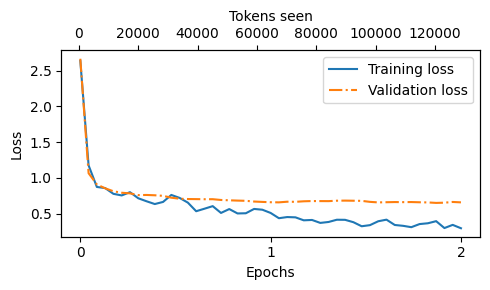

In [36]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

The model's performance on both the training and validation sets improves substantially over the course of training. The rapid decrease in losses during the initial phase indicates that the model quickly learns meaningful patterns and representations from the data. Then, as training progresses to the second epoch, the losses continue to decrease but at a slower rate, suggesting that the model is fine-tuning its learned representations and converging to a stable solution.

Next, let's extract the responses and store them in a format that allows us to evaluate and quantify the response quality.

# **Stage 3: Evaluating the LLM**

Having fine-tuned the LLM on the training portion of the instruction datasaet, we are now ready to evaluate its performance on the held-out test set.

In [37]:
torch.manual_seed(123)

for entry in test_data[:3]:
    input_text = format_input(entry)
    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):].replace("### Response: ", "").strip()
    )


    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response: \n>> {response_text.strip()}")
    print("\n----------------------------------------------\n")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response: 
>> ### Response:
The car is as fast as a bullet.

----------------------------------------------

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response: 
>> ### Response:
The type of cloud associated with thunderstorms is a cumulus cloud.

----------------------------------------------

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct response:
>> Jane Auste

In [38]:
# Generating test set response

from tqdm import tqdm
for i, entry in tqdm(enumerate(test_data), total=len(test_data)):
    input_text = format_input(entry)
    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):].replace("### Response: ", "").strip()
    )
    test_data[i]["model_response"] = response_text

with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)


100%|██████████| 110/110 [01:18<00:00,  1.41it/s]


Let's verify that the responses have been correctly added to the test_set dictionary by examining one of the entries.

In [39]:
print(test_data[0])

{'instruction': 'Rewrite the sentence using a simile.', 'input': 'The car is very fast.', 'output': 'The car is as fast as lightning.', 'model_response': '### Response:\nThe car is as fast as a bullet.'}


Finally, we save the model `gpt2-medium355M-sft.pth` file to be able to reuse it in future projects.

In [40]:
import re

file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

Model saved as gpt2-medium355M-sft.pth


The saved model can then be loaded via `model.load_state_dict(torch.load("gpt2-medium355M-sft.pth))`

### Evaluating the fine-tuned LLM

Previously, we judged the performance of an instruction-fine-tuned model by looking at its responses on three examples of the test set. While this gives us a rough idea of how well the model performs, this method does not scale well to larger amounts of responses. So, we implement a method to automate the response evaluation of the fine-tuned LLM using another, larger LLM.

To evaluate test set responses in an automated fashion, we utilize an existing instruction-fine-tuned 8-billion-parameter Llama 3 model developed by Meta AI.

In [41]:
#Download ollama
!curl -fsSL https://ollama.com/install.sh | sh
import subprocess
process = subprocess.Popen("ollama serve", shell=True) #runs on a different thread
#Download model
!ollama pull llama3
!pip install ollama
import ollama

>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
############################################################################################# 100.0%                                                                              19.2%#################################################################################            90.1%##############################################################################         93.1%
>>> Creating ollama user...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.
Couldn't find '/root/.ollama/id_ed25519'. Generating new private key.
Your new public key is: 

ssh-ed25519 AAAAC3NzaC1lZDI1NTE5AAAAIGoiVkPSc0ZQq+rCcbHufVOmOVhGTp41TADDztKQk88F



time=2025-05-22T05:33:12.511Z level=INFO source=routes.go:1205 msg="server config" env="map[CUDA_VISIBLE_DEVICES: GPU_DEVICE_ORDINAL: HIP_VISIBLE_DEVICES: HSA_OVERRIDE_GFX_VERSION: HTTPS_PROXY: HTTP_PROXY: NO_PROXY: OLLAMA_CONTEXT_LENGTH:4096 OLLAMA_DEBUG:INFO OLLAMA_FLASH_ATTENTION:false OLLAMA_GPU_OVERHEAD:0 OLLAMA_HOST:http://127.0.0.1:11434 OLLAMA_INTEL_GPU:false OLLAMA_KEEP_ALIVE:5m0s OLLAMA_KV_CACHE_TYPE: OLLAMA_LLM_LIBRARY: OLLAMA_LOAD_TIMEOUT:5m0s OLLAMA_MAX_LOADED_MODELS:0 OLLAMA_MAX_QUEUE:512 OLLAMA_MODELS:/root/.ollama/models OLLAMA_MULTIUSER_CACHE:false OLLAMA_NEW_ENGINE:false OLLAMA_NOHISTORY:false OLLAMA_NOPRUNE:false OLLAMA_NUM_PARALLEL:0 OLLAMA_ORIGINS:[http://localhost https://localhost http://localhost:* https://localhost:* http://127.0.0.1 https://127.0.0.1 http://127.0.0.1:* https://127.0.0.1:* http://0.0.0.0 https://0.0.0.0 http://0.0.0.0:* https://0.0.0.0:* app://* file://* tauri://* vscode-webview://* vscode-file://*] OLLAMA_SCHED_SPREAD:false ROCR_VISIBLE_DEVICE

[GIN] 2025/05/22 - 05:33:12 | 200 |      69.494µs |       127.0.0.1 | HEAD     "/"
pulling manifest ⠋ 

time=2025-05-22T05:33:12.811Z level=INFO source=types.go:130 msg="inference compute" id=GPU-9c320a8a-da1e-3b18-7c55-060064962ea0 library=cuda variant=v12 compute=7.5 driver=12.6 name="Tesla T4" total="14.7 GiB" available="6.5 GiB"
time=2025-05-22T05:33:12.811Z level=INFO source=types.go:130 msg="inference compute" id=GPU-f9eff93c-510c-5e4d-8301-2af4f53e5c32 library=cuda variant=v12 compute=7.5 driver=12.6 name="Tesla T4" total="14.7 GiB" available="14.6 GiB"


pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ 

time=2025-05-22T05:33:13.328Z level=INFO source=download.go:177 msg="downloading 6a0746a1ec1a in 16 291 MB part(s)"


pulling manifest 
pulling 6a0746a1ec1a:   0% ▕                  ▏ 2.8 MB/4.7 GB                  pulling manifest 
pulling 6a0746a1ec1a:   1% ▕                  ▏  62 MB/4.7 GB                  pulling manifest 
pulling 6a0746a1ec1a:   2% ▕                  ▏ 102 MB/4.7 GB                  pulling manifest 
pulling 6a0746a1ec1a:   4% ▕                  ▏ 183 MB/4.7 GB                  pulling manifest 
pulling 6a0746a1ec1a:   6% ▕█                 ▏ 264 MB/4.7 GB                  pulling manifest 
pulling 6a0746a1ec1a:   7% ▕█                 ▏ 346 MB/4.7 GB                  pulling manifest 
pulling 6a0746a1ec1a:   8% ▕█                 ▏ 386 MB/4.7 GB                  pulling manifest 
pulling 6a0746a1ec1a:  10% ▕█                 ▏ 468 MB/4.7 GB                  pulling manifest 
pulling 6a0746a1ec1a:  12% ▕██                ▏ 550 MB/4.7 GB                  pulling manifest 
pulling 6a0746a1ec1a:  13% ▕██                ▏ 590 MB/4.7 GB                  pulling manifest 
pulling 6a07

time=2025-05-22T05:33:30.295Z level=INFO source=download.go:177 msg="downloading 4fa551d4f938 in 1 12 KB part(s)"


pulling manifest 
pulling 6a0746a1ec1a: 100% ▕██████████████████▏ 4.7 GB                         
pulling 4fa551d4f938: 100% ▕██████████████████▏  12 KB                         pulling manifest 
pulling 6a0746a1ec1a: 100% ▕██████████████████▏ 4.7 GB                         
pulling 4fa551d4f938: 100% ▕██████████████████▏  12 KB                         pulling manifest 
pulling 6a0746a1ec1a: 100% ▕██████████████████▏ 4.7 GB                         
pulling 4fa551d4f938: 100% ▕██████████████████▏  12 KB                         pulling manifest 
pulling 6a0746a1ec1a: 100% ▕██████████████████▏ 4.7 GB                         
pulling 4fa551d4f938: 100% ▕██████████████████▏  12 KB                         pulling manifest 
pulling 6a0746a1ec1a: 100% ▕██████████████████▏ 4.7 GB                         
pulling 4fa551d4f938: 100% ▕██████████████████▏  12 KB                         pulling manifest 
pulling 6a0746a1ec1a: 100% ▕██████████████████▏ 4.7 GB                         
pulling 4fa551d4f

time=2025-05-22T05:33:31.461Z level=INFO source=download.go:177 msg="downloading 8ab4849b038c in 1 254 B part(s)"


pulling manifest 
pulling 6a0746a1ec1a: 100% ▕██████████████████▏ 4.7 GB                         
pulling 4fa551d4f938: 100% ▕██████████████████▏  12 KB                         
pulling 8ab4849b038c: 100% ▕██████████████████▏  254 B                         pulling manifest 
pulling 6a0746a1ec1a: 100% ▕██████████████████▏ 4.7 GB                         
pulling 4fa551d4f938: 100% ▕██████████████████▏  12 KB                         
pulling 8ab4849b038c: 100% ▕██████████████████▏  254 B                         pulling manifest 
pulling 6a0746a1ec1a: 100% ▕██████████████████▏ 4.7 GB                         
pulling 4fa551d4f938: 100% ▕██████████████████▏  12 KB                         
pulling 8ab4849b038c: 100% ▕██████████████████▏  254 B                         pulling manifest 
pulling 6a0746a1ec1a: 100% ▕██████████████████▏ 4.7 GB                         
pulling 4fa551d4f938: 100% ▕██████████████████▏  12 KB                         
pulling 8ab4849b038c: 100% ▕██████████████████▏  25

time=2025-05-22T05:33:32.611Z level=INFO source=download.go:177 msg="downloading 577073ffcc6c in 1 110 B part(s)"


pulling manifest 
pulling 6a0746a1ec1a: 100% ▕██████████████████▏ 4.7 GB                         
pulling 4fa551d4f938: 100% ▕██████████████████▏  12 KB                         
pulling 8ab4849b038c: 100% ▕██████████████████▏  254 B                         
pulling 577073ffcc6c: 100% ▕██████████████████▏  110 B                         pulling manifest 
pulling 6a0746a1ec1a: 100% ▕██████████████████▏ 4.7 GB                         
pulling 4fa551d4f938: 100% ▕██████████████████▏  12 KB                         
pulling 8ab4849b038c: 100% ▕██████████████████▏  254 B                         
pulling 577073ffcc6c: 100% ▕██████████████████▏  110 B                         pulling manifest 
pulling 6a0746a1ec1a: 100% ▕██████████████████▏ 4.7 GB                         
pulling 4fa551d4f938: 100% ▕██████████████████▏  12 KB                         
pulling 8ab4849b038c: 100% ▕██████████████████▏  254 B                         
pulling 577073ffcc6c: 100% ▕██████████████████▏  110 B              

time=2025-05-22T05:33:33.807Z level=INFO source=download.go:177 msg="downloading 3f8eb4da87fa in 1 485 B part(s)"


pulling manifest 
pulling 6a0746a1ec1a: 100% ▕██████████████████▏ 4.7 GB                         
pulling 4fa551d4f938: 100% ▕██████████████████▏  12 KB                         
pulling 8ab4849b038c: 100% ▕██████████████████▏  254 B                         
pulling 577073ffcc6c: 100% ▕██████████████████▏  110 B                         
pulling 3f8eb4da87fa: 100% ▕██████████████████▏  485 B                         pulling manifest 
pulling 6a0746a1ec1a: 100% ▕██████████████████▏ 4.7 GB                         
pulling 4fa551d4f938: 100% ▕██████████████████▏  12 KB                         
pulling 8ab4849b038c: 100% ▕██████████████████▏  254 B                         
pulling 577073ffcc6c: 100% ▕██████████████████▏  110 B                         
pulling 3f8eb4da87fa: 100% ▕██████████████████▏  485 B                         pulling manifest 
pulling 6a0746a1ec1a: 100% ▕██████████████████▏ 4.7 GB                         
pulling 4fa551d4f938: 100% ▕██████████████████▏  12 KB              

The following code verifies that the Ollama session is running properly before we use Ollama to evaluate the test set responses.

In [42]:
import psutil

def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info["name"]:
            running = True
            break
    return running
ollama_running = check_if_running("ollama")
if not ollama_running:
    raise RuntimeError(
        "Ollama not running. Launch ollama before proceeding."
    )
print("Ollama running:", check_if_running("ollama"))

Ollama running: True


"Ollama running: True" confirms that the model is active and ready to receive requests.

In [43]:
# Query a local Ollama modeimport urllib.request
import json
from tqdm import tqdm

def query_model(
    prompt,
    model="llama3",
    url="http://localhost:11434/api/chat"
):
    """
    Query a local Ollama model running in Kaggle.
    
    Args:
        prompt (str): The input prompt to send to the model
        model (str): The model name to use (default: "llama3")
        url (str): The API endpoint URL (default: local Ollama)
        
    Returns:
        str: The model's response
    """
    data = {
        "model": model,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "options": {
            "seed": 123,
            "temperature": 0,
            "num_ctx": 2048
        }
    }
    
    payload = json.dumps(data).encode("utf-8")
    request = urllib.request.Request(
        url,
        data=payload,
        method="POST"
    )
    request.add_header("Content-Type", "application/json")
    
    response_data = ""
    try:
        with urllib.request.urlopen(request) as response:
            while True:
                line = response.readline().decode("utf-8")
                if not line:
                    break
                response_json = json.loads(line)
                response_data += response_json["message"]["content"]
    except Exception as e:
        print(f"Error querying model: {e}")
        return None
    
    return response_data

In [44]:
model = "llama3"
result = query_model("What do Llamas eat?", model)
print(result)

time=2025-05-22T05:33:55.778Z level=INFO source=sched.go:777 msg="new model will fit in available VRAM in single GPU, loading" model=/root/.ollama/models/blobs/sha256-6a0746a1ec1aef3e7ec53868f220ff6e389f6f8ef87a01d77c96807de94ca2aa gpu=GPU-f9eff93c-510c-5e4d-8301-2af4f53e5c32 parallel=2 available=15720382464 required="5.7 GiB"
time=2025-05-22T05:33:55.990Z level=INFO source=server.go:135 msg="system memory" total="31.4 GiB" free="26.4 GiB" free_swap="0 B"
time=2025-05-22T05:33:55.991Z level=INFO source=server.go:168 msg=offload library=cuda layers.requested=-1 layers.model=33 layers.offload=33 layers.split="" memory.available="[14.6 GiB]" memory.gpu_overhead="0 B" memory.required.full="5.7 GiB" memory.required.partial="5.7 GiB" memory.required.kv="512.0 MiB" memory.required.allocations="[5.7 GiB]" memory.weights.total="4.1 GiB" memory.weights.repeating="3.7 GiB" memory.weights.nonrepeating="411.0 MiB" memory.graph.full="296.0 MiB" memory.graph.partial="677.5 MiB"
llama_model_loader: lo

[GIN] 2025/05/22 - 05:34:08 | 200 | 13.236453443s |       127.0.0.1 | POST     "/api/chat"
Llamas are herbivores, which means they primarily feed on plant-based foods. Their diet typically consists of:

1. Grasses: Llamas love to graze on various types of grasses, including tall grasses, short grasses, and even weeds.
2. Hay: High-quality hay, such as alfalfa or timothy hay, is a staple in a llama's diet. They enjoy munching on hay cubes or loose hay.
3. Grains: Llamas may receive grains like oats, barley, or corn as part of their diet. However, it's essential to provide these grains in moderation, as they can be high in calories and low in fiber.
4. Fruits and vegetables: Llamas enjoy a variety of fruits and veggies, such as apples, carrots, sweet potatoes, and leafy greens like kale or spinach.
5. Minerals: Llamas need access to mineral supplements, which provide essential nutrients like calcium, phosphorus, and salt.

In the wild, llamas might also eat:

1. Leaves: They'll munch on 

First, we apply this approach to the first three examples from the test set that we previously examined.

In [45]:
for entry in test_data[:3]:
    # Format the evaluation prompt
    prompt = (
        f"Given the input: `{format_input(entry)}`\n"
        f"and the correct output: `{entry['output']}`\n"
        f"Score the model response: `{entry['model_response']}`\n"
        f"Provide a numerical score from 0 to 100 (where 100 is perfect) "
        f"and a brief explanation for your score.\n"
        f"Format your response as: 'Score: X | Explanation: ...'"
    )
    
    # Print the comparison
    print("\n" + "="*50)
    print("\n### Input Instruction:")
    print(format_input(entry))
    
    print("\n### Dataset Expected Response:")
    print(">>", entry['output'])
    
    print("\n### Model Generated Response:")
    print(">>", entry["model_response"])
    
    # Get and print the evaluation
    print("\n### Evaluation:")
    evaluation = query_model(prompt)
    print(">>", evaluation if evaluation else "Error getting evaluation")
    print("\n" + "="*50)



### Input Instruction:
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

### Dataset Expected Response:
>> The car is as fast as lightning.

### Model Generated Response:
>> ### Response:
The car is as fast as a bullet.

### Evaluation:
[GIN] 2025/05/22 - 05:34:11 | 200 |   2.38005585s |       127.0.0.1 | POST     "/api/chat"
>> Score: 80 | Explanation: The model's response, "The car is as fast as a bullet," is close to the correct output, but not exactly what was requested. The input asked for a simile that compares the car's speed to lightning, whereas the model responded with a comparison to a bullet. While both comparisons are vivid and convey a sense of speed, they are not identical to the original request.



### Input Instruction:
Below is an instruction that describes a task. Write a response that appropriately completes the request

The generated responses show that the Llama 3 model provides a reasonable evaluations and is capable of assigning partial points when a model's answer is not entirely correct.

In [60]:
from tqdm import tqdm

def generate_model_score(json_data, json_key, model="llama3"):
    scores = []
    for entry in tqdm(json_data, desc="Scoring entries"):
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry[json_key]}` "
            f"on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."
        )
        score = query_model(prompt, model)

        # Try to extract just the first integer from the response
        try:
            score_int = int(''.join(filter(str.isdigit, score.strip().split()[0])))
            scores.append(score_int)
        except Exception:
            print(f"Could not convert score: {score}")
            continue

    return scores


Let's now apply the `generate_model_scores` function to the entire `test_data` set.

In [61]:
scores = generate_model_score(test_data, "model_response")
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores)/len(scores): .2f}\n")

Scoring entries:   2%|▏         | 2/110 [00:00<00:20,  5.32it/s]

[GIN] 2025/05/22 - 05:40:06 | 200 |  238.249027ms |       127.0.0.1 | POST     "/api/chat"
[GIN] 2025/05/22 - 05:40:06 | 200 |  150.182234ms |       127.0.0.1 | POST     "/api/chat"


Scoring entries:   4%|▎         | 4/110 [00:00<00:16,  6.37it/s]

[GIN] 2025/05/22 - 05:40:06 | 200 |  140.653572ms |       127.0.0.1 | POST     "/api/chat"
[GIN] 2025/05/22 - 05:40:07 | 200 |  139.613035ms |       127.0.0.1 | POST     "/api/chat"


Scoring entries:   5%|▌         | 6/110 [00:00<00:15,  6.68it/s]

[GIN] 2025/05/22 - 05:40:07 | 200 |  142.369348ms |       127.0.0.1 | POST     "/api/chat"
[GIN] 2025/05/22 - 05:40:07 | 200 |  142.571011ms |       127.0.0.1 | POST     "/api/chat"


Scoring entries:   7%|▋         | 8/110 [00:01<00:15,  6.68it/s]

[GIN] 2025/05/22 - 05:40:07 | 200 |  160.283331ms |       127.0.0.1 | POST     "/api/chat"
[GIN] 2025/05/22 - 05:40:07 | 200 |  139.215288ms |       127.0.0.1 | POST     "/api/chat"


Scoring entries:   9%|▉         | 10/110 [00:01<00:15,  6.54it/s]

[GIN] 2025/05/22 - 05:40:07 | 200 |  141.909769ms |       127.0.0.1 | POST     "/api/chat"
[GIN] 2025/05/22 - 05:40:08 | 200 |  162.795919ms |       127.0.0.1 | POST     "/api/chat"


Scoring entries:  11%|█         | 12/110 [00:01<00:14,  6.77it/s]

[GIN] 2025/05/22 - 05:40:08 | 200 |  138.718792ms |       127.0.0.1 | POST     "/api/chat"
[GIN] 2025/05/22 - 05:40:08 | 200 |  142.313968ms |       127.0.0.1 | POST     "/api/chat"


Scoring entries:  13%|█▎        | 14/110 [00:02<00:13,  7.06it/s]

[GIN] 2025/05/22 - 05:40:08 | 200 |  142.844048ms |       127.0.0.1 | POST     "/api/chat"
[GIN] 2025/05/22 - 05:40:08 | 200 |  128.653085ms |       127.0.0.1 | POST     "/api/chat"


Scoring entries:  15%|█▍        | 16/110 [00:02<00:14,  6.52it/s]

[GIN] 2025/05/22 - 05:40:08 | 200 |   174.67302ms |       127.0.0.1 | POST     "/api/chat"
[GIN] 2025/05/22 - 05:40:08 | 200 |  154.335858ms |       127.0.0.1 | POST     "/api/chat"


Scoring entries:  16%|█▋        | 18/110 [00:02<00:13,  6.74it/s]

[GIN] 2025/05/22 - 05:40:09 | 200 |  139.973004ms |       127.0.0.1 | POST     "/api/chat"
[GIN] 2025/05/22 - 05:40:09 | 200 |  143.371078ms |       127.0.0.1 | POST     "/api/chat"


Scoring entries:  18%|█▊        | 20/110 [00:03<00:13,  6.81it/s]

[GIN] 2025/05/22 - 05:40:09 | 200 |   143.70453ms |       127.0.0.1 | POST     "/api/chat"
[GIN] 2025/05/22 - 05:40:09 | 200 |  143.445954ms |       127.0.0.1 | POST     "/api/chat"


Scoring entries:  20%|██        | 22/110 [00:03<00:12,  6.80it/s]

[GIN] 2025/05/22 - 05:40:09 | 200 |   151.12118ms |       127.0.0.1 | POST     "/api/chat"
[GIN] 2025/05/22 - 05:40:09 | 200 |  142.075172ms |       127.0.0.1 | POST     "/api/chat"


Scoring entries:  22%|██▏       | 24/110 [00:03<00:12,  6.68it/s]

[GIN] 2025/05/22 - 05:40:09 | 200 |  143.060032ms |       127.0.0.1 | POST     "/api/chat"
[GIN] 2025/05/22 - 05:40:10 | 200 |  155.911101ms |       127.0.0.1 | POST     "/api/chat"


Scoring entries:  24%|██▎       | 26/110 [00:03<00:12,  6.60it/s]

[GIN] 2025/05/22 - 05:40:10 | 200 |  142.824888ms |       127.0.0.1 | POST     "/api/chat"
[GIN] 2025/05/22 - 05:40:10 | 200 |  157.264201ms |       127.0.0.1 | POST     "/api/chat"


Scoring entries:  25%|██▌       | 28/110 [00:04<00:12,  6.57it/s]

[GIN] 2025/05/22 - 05:40:10 | 200 |  145.522198ms |       127.0.0.1 | POST     "/api/chat"
[GIN] 2025/05/22 - 05:40:10 | 200 |  154.839908ms |       127.0.0.1 | POST     "/api/chat"


Scoring entries:  27%|██▋       | 30/110 [00:04<00:11,  6.77it/s]

[GIN] 2025/05/22 - 05:40:10 | 200 |  142.803797ms |       127.0.0.1 | POST     "/api/chat"
[GIN] 2025/05/22 - 05:40:10 | 200 |  140.557676ms |       127.0.0.1 | POST     "/api/chat"


Scoring entries:  29%|██▉       | 32/110 [00:04<00:11,  6.83it/s]

[GIN] 2025/05/22 - 05:40:11 | 200 |  143.298439ms |       127.0.0.1 | POST     "/api/chat"
[GIN] 2025/05/22 - 05:40:11 | 200 |  143.701484ms |       127.0.0.1 | POST     "/api/chat"


Scoring entries:  31%|███       | 34/110 [00:05<00:11,  6.66it/s]

[GIN] 2025/05/22 - 05:40:11 | 200 |  165.227019ms |       127.0.0.1 | POST     "/api/chat"
[GIN] 2025/05/22 - 05:40:11 | 200 |  143.101899ms |       127.0.0.1 | POST     "/api/chat"


Scoring entries:  33%|███▎      | 36/110 [00:05<00:10,  6.78it/s]

[GIN] 2025/05/22 - 05:40:11 | 200 |   143.28351ms |       127.0.0.1 | POST     "/api/chat"
[GIN] 2025/05/22 - 05:40:11 | 200 |  143.306571ms |       127.0.0.1 | POST     "/api/chat"


Scoring entries:  35%|███▍      | 38/110 [00:05<00:10,  6.85it/s]

[GIN] 2025/05/22 - 05:40:12 | 200 |  140.854579ms |       127.0.0.1 | POST     "/api/chat"
[GIN] 2025/05/22 - 05:40:12 | 200 |  143.927564ms |       127.0.0.1 | POST     "/api/chat"


Scoring entries:  36%|███▋      | 40/110 [00:06<00:10,  6.53it/s]

[GIN] 2025/05/22 - 05:40:12 | 200 |  148.374402ms |       127.0.0.1 | POST     "/api/chat"
[GIN] 2025/05/22 - 05:40:12 | 200 |  165.318809ms |       127.0.0.1 | POST     "/api/chat"


Scoring entries:  38%|███▊      | 42/110 [00:06<00:10,  6.55it/s]

[GIN] 2025/05/22 - 05:40:12 | 200 |  143.975539ms |       127.0.0.1 | POST     "/api/chat"
[GIN] 2025/05/22 - 05:40:12 | 200 |   154.93076ms |       127.0.0.1 | POST     "/api/chat"


Scoring entries:  40%|████      | 44/110 [00:06<00:09,  6.77it/s]

[GIN] 2025/05/22 - 05:40:12 | 200 |  156.097366ms |       127.0.0.1 | POST     "/api/chat"
[GIN] 2025/05/22 - 05:40:13 | 200 |  130.936932ms |       127.0.0.1 | POST     "/api/chat"


Scoring entries:  42%|████▏     | 46/110 [00:06<00:09,  7.02it/s]

[GIN] 2025/05/22 - 05:40:13 | 200 |  144.417649ms |       127.0.0.1 | POST     "/api/chat"
[GIN] 2025/05/22 - 05:40:13 | 200 |  129.600727ms |       127.0.0.1 | POST     "/api/chat"


Scoring entries:  44%|████▎     | 48/110 [00:07<00:08,  6.95it/s]

[GIN] 2025/05/22 - 05:40:13 | 200 |  144.601335ms |       127.0.0.1 | POST     "/api/chat"
[GIN] 2025/05/22 - 05:40:13 | 200 |  142.669827ms |       127.0.0.1 | POST     "/api/chat"


Scoring entries:  45%|████▌     | 50/110 [00:07<00:08,  7.17it/s]

[GIN] 2025/05/22 - 05:40:13 | 200 |  144.251806ms |       127.0.0.1 | POST     "/api/chat"
[GIN] 2025/05/22 - 05:40:13 | 200 |  125.929413ms |       127.0.0.1 | POST     "/api/chat"


Scoring entries:  47%|████▋     | 52/110 [00:07<00:08,  6.99it/s]

[GIN] 2025/05/22 - 05:40:14 | 200 |  142.802867ms |       127.0.0.1 | POST     "/api/chat"
[GIN] 2025/05/22 - 05:40:14 | 200 |  146.664633ms |       127.0.0.1 | POST     "/api/chat"


Scoring entries:  49%|████▉     | 54/110 [00:08<00:08,  6.68it/s]

[GIN] 2025/05/22 - 05:40:14 | 200 |  150.869577ms |       127.0.0.1 | POST     "/api/chat"
[GIN] 2025/05/22 - 05:40:14 | 200 |  156.856383ms |       127.0.0.1 | POST     "/api/chat"


Scoring entries:  51%|█████     | 56/110 [00:08<00:08,  6.47it/s]

[GIN] 2025/05/22 - 05:40:14 | 200 |  144.695094ms |       127.0.0.1 | POST     "/api/chat"
[GIN] 2025/05/22 - 05:40:14 | 200 |  166.708482ms |       127.0.0.1 | POST     "/api/chat"


Scoring entries:  53%|█████▎    | 58/110 [00:08<00:07,  6.58it/s]

[GIN] 2025/05/22 - 05:40:14 | 200 |  156.033826ms |       127.0.0.1 | POST     "/api/chat"
[GIN] 2025/05/22 - 05:40:15 | 200 |  142.619034ms |       127.0.0.1 | POST     "/api/chat"


Scoring entries:  55%|█████▍    | 60/110 [00:08<00:07,  6.59it/s]

[GIN] 2025/05/22 - 05:40:15 | 200 |  143.275234ms |       127.0.0.1 | POST     "/api/chat"
[GIN] 2025/05/22 - 05:40:15 | 200 |  154.153688ms |       127.0.0.1 | POST     "/api/chat"


Scoring entries:  56%|█████▋    | 62/110 [00:09<00:07,  6.65it/s]

[GIN] 2025/05/22 - 05:40:15 | 200 |  143.185322ms |       127.0.0.1 | POST     "/api/chat"
[GIN] 2025/05/22 - 05:40:15 | 200 |  150.094271ms |       127.0.0.1 | POST     "/api/chat"


Scoring entries:  58%|█████▊    | 64/110 [00:09<00:06,  6.72it/s]

[GIN] 2025/05/22 - 05:40:15 | 200 |  145.618272ms |       127.0.0.1 | POST     "/api/chat"
[GIN] 2025/05/22 - 05:40:16 | 200 |  145.968175ms |       127.0.0.1 | POST     "/api/chat"


Scoring entries:  60%|██████    | 66/110 [00:09<00:06,  6.67it/s]

[GIN] 2025/05/22 - 05:40:16 | 200 |   144.43342ms |       127.0.0.1 | POST     "/api/chat"
[GIN] 2025/05/22 - 05:40:16 | 200 |  152.632204ms |       127.0.0.1 | POST     "/api/chat"


Scoring entries:  62%|██████▏   | 68/110 [00:10<00:06,  6.72it/s]

[GIN] 2025/05/22 - 05:40:16 | 200 |  144.902955ms |       127.0.0.1 | POST     "/api/chat"
[GIN] 2025/05/22 - 05:40:16 | 200 |  146.784326ms |       127.0.0.1 | POST     "/api/chat"


Scoring entries:  64%|██████▎   | 70/110 [00:10<00:06,  6.65it/s]

[GIN] 2025/05/22 - 05:40:16 | 200 |  158.141167ms |       127.0.0.1 | POST     "/api/chat"
[GIN] 2025/05/22 - 05:40:16 | 200 |  144.847157ms |       127.0.0.1 | POST     "/api/chat"


Scoring entries:  65%|██████▌   | 72/110 [00:10<00:05,  6.55it/s]

[GIN] 2025/05/22 - 05:40:17 | 200 |  151.256119ms |       127.0.0.1 | POST     "/api/chat"
[GIN] 2025/05/22 - 05:40:17 | 200 |  154.668139ms |       127.0.0.1 | POST     "/api/chat"


Scoring entries:  67%|██████▋   | 74/110 [00:11<00:05,  6.60it/s]

[GIN] 2025/05/22 - 05:40:17 | 200 |  154.395491ms |       127.0.0.1 | POST     "/api/chat"
[GIN] 2025/05/22 - 05:40:17 | 200 |  144.130718ms |       127.0.0.1 | POST     "/api/chat"


Scoring entries:  69%|██████▉   | 76/110 [00:11<00:05,  6.63it/s]

[GIN] 2025/05/22 - 05:40:17 | 200 |  155.967672ms |       127.0.0.1 | POST     "/api/chat"
[GIN] 2025/05/22 - 05:40:17 | 200 |  143.552243ms |       127.0.0.1 | POST     "/api/chat"


Scoring entries:  71%|███████   | 78/110 [00:11<00:04,  6.56it/s]

[GIN] 2025/05/22 - 05:40:17 | 200 |  146.029339ms |       127.0.0.1 | POST     "/api/chat"
[GIN] 2025/05/22 - 05:40:18 | 200 |  156.390975ms |       127.0.0.1 | POST     "/api/chat"


Scoring entries:  73%|███████▎  | 80/110 [00:12<00:04,  6.58it/s]

[GIN] 2025/05/22 - 05:40:18 | 200 |  158.736739ms |       127.0.0.1 | POST     "/api/chat"
[GIN] 2025/05/22 - 05:40:18 | 200 |  143.698389ms |       127.0.0.1 | POST     "/api/chat"


Scoring entries:  75%|███████▍  | 82/110 [00:12<00:04,  6.61it/s]

[GIN] 2025/05/22 - 05:40:18 | 200 |  153.973498ms |       127.0.0.1 | POST     "/api/chat"
[GIN] 2025/05/22 - 05:40:18 | 200 |   144.46237ms |       127.0.0.1 | POST     "/api/chat"


Scoring entries:  76%|███████▋  | 84/110 [00:12<00:03,  6.60it/s]

[GIN] 2025/05/22 - 05:40:18 | 200 |  157.331191ms |       127.0.0.1 | POST     "/api/chat"
[GIN] 2025/05/22 - 05:40:19 | 200 |  145.663066ms |       127.0.0.1 | POST     "/api/chat"


Scoring entries:  78%|███████▊  | 86/110 [00:12<00:03,  6.59it/s]

[GIN] 2025/05/22 - 05:40:19 | 200 |  154.386398ms |       127.0.0.1 | POST     "/api/chat"
[GIN] 2025/05/22 - 05:40:19 | 200 |  147.425086ms |       127.0.0.1 | POST     "/api/chat"


Scoring entries:  79%|███████▉  | 87/110 [00:13<00:03,  6.66it/s]

[GIN] 2025/05/22 - 05:40:19 | 200 |  144.377758ms |       127.0.0.1 | POST     "/api/chat"


Scoring entries:  81%|████████  | 89/110 [00:13<00:04,  4.94it/s]

[GIN] 2025/05/22 - 05:40:19 | 200 |  396.570246ms |       127.0.0.1 | POST     "/api/chat"
[GIN] 2025/05/22 - 05:40:20 | 200 |  147.915889ms |       127.0.0.1 | POST     "/api/chat"


Scoring entries:  83%|████████▎ | 91/110 [00:13<00:03,  5.76it/s]

[GIN] 2025/05/22 - 05:40:20 | 200 |  143.798118ms |       127.0.0.1 | POST     "/api/chat"
[GIN] 2025/05/22 - 05:40:20 | 200 |  144.516189ms |       127.0.0.1 | POST     "/api/chat"


Scoring entries:  85%|████████▍ | 93/110 [00:14<00:02,  6.16it/s]

[GIN] 2025/05/22 - 05:40:20 | 200 |  146.884093ms |       127.0.0.1 | POST     "/api/chat"
[GIN] 2025/05/22 - 05:40:20 | 200 |  151.703594ms |       127.0.0.1 | POST     "/api/chat"


Scoring entries:  86%|████████▋ | 95/110 [00:14<00:02,  6.37it/s]

[GIN] 2025/05/22 - 05:40:20 | 200 |  157.774215ms |       127.0.0.1 | POST     "/api/chat"
[GIN] 2025/05/22 - 05:40:20 | 200 |  144.300148ms |       127.0.0.1 | POST     "/api/chat"


Scoring entries:  88%|████████▊ | 97/110 [00:14<00:01,  6.52it/s]

[GIN] 2025/05/22 - 05:40:21 | 200 |  155.913118ms |       127.0.0.1 | POST     "/api/chat"
[GIN] 2025/05/22 - 05:40:21 | 200 |  143.177247ms |       127.0.0.1 | POST     "/api/chat"


Scoring entries:  90%|█████████ | 99/110 [00:15<00:01,  6.78it/s]

[GIN] 2025/05/22 - 05:40:21 | 200 |  132.110364ms |       127.0.0.1 | POST     "/api/chat"
[GIN] 2025/05/22 - 05:40:21 | 200 |  145.358915ms |       127.0.0.1 | POST     "/api/chat"


Scoring entries:  92%|█████████▏| 101/110 [00:15<00:01,  6.79it/s]

[GIN] 2025/05/22 - 05:40:21 | 200 |  147.031402ms |       127.0.0.1 | POST     "/api/chat"
[GIN] 2025/05/22 - 05:40:21 | 200 |  143.884411ms |       127.0.0.1 | POST     "/api/chat"


Scoring entries:  94%|█████████▎| 103/110 [00:15<00:01,  6.39it/s]

[GIN] 2025/05/22 - 05:40:21 | 200 |   146.20573ms |       127.0.0.1 | POST     "/api/chat"
[GIN] 2025/05/22 - 05:40:22 | 200 |  176.442688ms |       127.0.0.1 | POST     "/api/chat"


Scoring entries:  95%|█████████▍| 104/110 [00:15<00:00,  6.70it/s]

[GIN] 2025/05/22 - 05:40:22 | 200 |  130.078479ms |       127.0.0.1 | POST     "/api/chat"


Scoring entries:  96%|█████████▋| 106/110 [00:16<00:00,  5.99it/s]

[GIN] 2025/05/22 - 05:40:22 | 200 |  236.907148ms |       127.0.0.1 | POST     "/api/chat"
[GIN] 2025/05/22 - 05:40:22 | 200 |  144.097308ms |       127.0.0.1 | POST     "/api/chat"


Scoring entries:  98%|█████████▊| 108/110 [00:16<00:00,  6.22it/s]

[GIN] 2025/05/22 - 05:40:22 | 200 |  147.850702ms |       127.0.0.1 | POST     "/api/chat"
[GIN] 2025/05/22 - 05:40:22 | 200 |  156.470232ms |       127.0.0.1 | POST     "/api/chat"


Scoring entries: 100%|██████████| 110/110 [00:16<00:00,  6.53it/s]

[GIN] 2025/05/22 - 05:40:23 | 200 |  145.892255ms |       127.0.0.1 | POST     "/api/chat"
[GIN] 2025/05/22 - 05:40:23 | 200 |  152.821235ms |       127.0.0.1 | POST     "/api/chat"
Number of scores: 110 of 110
Average score:  44.05

